# Predicting Gender from Personality Questions

This notebook goes through the process of building various simple models to predict gender from the answers on personality questions.  There is a lot of exploration in this notebook--much more so than necessary--to show the variation in performance between the different model types.  The general methodology for this process will be to fit multiple "standard" models (of the same model type) and select the best one for parameter tuning and optimization.  This methodology isn't exactly *ideal*, because it is very possible for one of the non-selected models to have the best performance after tuning--but it works *good enough* in most situations.  In a situation where there's a huge cost to misclassification then it would be more appropriate to get into the more extreme edges of model tuning--but this ain't it.

In the next notebook, information discovered here will be used with other techniques to build a single good model that predicts gender from personality questions.

**Note:** In this exploration, I did not split use a hold-away test set to evaluate the best hyperparameters after tuning.  For this notebook, I was mainly looking to get a feel for which models to use in an ensemble and get a rough estimate of potential max accuracy.  I'm well aware that you cannot use crossvalidation to tune hyperparameters and have the crossvalidation accuracy be a reliable indicator of the actual accuracy of the model.  Said crossval accuracy will, however, give me an approximate upperbound I can expect out of each model because I don't, in general, expect performance to be better on a held-away test set than on the data the hyperparameters were tuned on.  In the next notebook planned (where I actually build the ensemble model), a proper train/test split will be used with *nothing* being done to the models on the test set outside of evaluating accuracy.

If you have feedback (positive or negative) for me, I'd love to hear it and would be forever grateful.  Even on the presentation itself--I definitely know my aesthetics definitely need work.  I know that various cells were run out of order but I promise that the entire notebook works from start to finish with no issues.  Running them out-of-order was a workaround for needing to close my laptop to transport it and Jupyter Notebooks not currently allowing output to save to the notebook without notebook open in a browser.

## Table of Contents

- [Load Data and Libraries](#load_data)
- [Data Preparation](#data_prep)
- [Logarithmic Regression Models](#log_reg)
- [Naive-Bayes Models](#nb)
- [Support Vector Machine Models](#svm)
- [K-Nearest Neighbors Models](#knn)
- [Ensemble Decision Tree Models](#trees)
- [Conclusions](#conclusion)

<a id="load_data"></a>
## Load Data and Install Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
import time
%matplotlib inline

df = pd.read_csv('data_trans.csv', encoding='utf-8')
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,gender,accuracy,country,source,elapsed,sqrtbox_age,box_accuracy,box_elapsed,bin_age,bin_country
0,1,4,2,3,3,2,3,4,4,3,...,1,92,US,5,914,1.683215,2.270186,9.774004,0,US
1,4,3,4,3,4,4,4,4,2,2,...,1,100,US,0,891,1.900242,2.287068,9.723672,4,US
2,3,4,4,4,4,4,4,3,2,2,...,1,80,US,5,903,1.853102,2.240760,9.750076,3,US
3,4,5,4,4,4,3,3,2,2,2,...,1,93,US,0,806,1.861649,2.272403,9.526909,3,US
4,4,0,4,4,4,3,5,1,2,4,...,2,87,NZ,0,1826,1.956691,2.258593,11.190933,4,Other


<a id="data_prep"></a>
## Data Preparation

### Remove Invalid Data

As we removed all rows that had invalid data in the feature (personality questions) columns in the EDA phase, we only need to remove invalid data in the target variable (gender).  From the variable descriptions, any gender represented by 0 means that no answer was provided so they'll be absolutely no help to us (obvi).  It should be noted that the features all exist on the same scale and thus don't need to be scaled or normalized to avoid one feature overpowering other features in the model.

In [3]:
df.gender.value_counts(dropna=False)
og_count = df.shape[0]
print('\nTotal rows of data: '+str(og_count))
df = df[df.gender!=0]
new_count = df.shape[0]
print("\nNumber of rows remaining after deleting 'no answer' genders: "+str(new_count))
print("\nTotal number of rows removed: "+str(og_count-new_count))
print("\nValue counts for gender: ")
values = df.gender.value_counts()
print(values)
print("\nWomen as a pct of total data: "+str(values[2]/new_count))
print("\nMen as a pct of total data: "+str(values[1]/new_count))
print("\nNon-binary as a pct of total data: "+str(values[3]/new_count))


Total rows of data: 48779

Number of rows remaining after deleting 'no answer' genders: 48543

Total number of rows removed: 236

Value counts for gender: 
2    29046
1    19227
3      270
Name: gender, dtype: int64

Women as a pct of total data: 0.5983560966565725

Men as a pct of total data: 0.3960818243619059

Non-binary as a pct of total data: 0.0055620789815215375


As seen in the EDA, this data is pretty imbalanced with a lot of data on women (about 60% of the total) and very, very, very few non-binary genders (about 0.5% total).  This will really limit the ability of our models to predict non-binary gender.

### Simplifying the Data

The models will be evaluated using stratified k-fold crossvalidation.  We will drop binary gender for now and treat this as a binary classification problem.  Later on we will work to expand the results and see if we can make useful predictions for whether someone is non-binary or not, too.

In [4]:
rando_seed = 17

non_features = ['age', 'accuracy', 'elapsed', 'gender', 'source', 'country',
               'sqrtbox_age', 'box_accuracy', 'box_elapsed', 'bin_age', 'bin_country']

# create a copy dataset but drop all non-binary genders (which makes it a binary classification problem)
# re-code binary variables to be 0/1 instead of 1/2
X = df.drop(non_features, axis=1)
y = df.gender
X = X[y>0]
y = y[y>0]
X_bi = X[y<3]
y_bi = y[y<3]
y_bi = y_bi-1


In [5]:
print('Distribution of binary target variable: ')
y_bi.value_counts()

Distribution of binary target variable: 


1    29046
0    19227
Name: gender, dtype: int64

In [6]:
print(f"Total number of data points: {str(len(X_bi))}")

Total number of data points: 48273


### Heavily Used Functions for this Notebook
Below are a couple function I'm going to use to make this analysis more streamlined and effective.  Instead of using sklearn's cross_val_score function to estimate crossvalidation accuracy, I'll be using a custom function which does the same thing but will allow me to include multiple metrics as well as return the accuracy scores for the training data for each fold (as opposed to just the test accuracy for each fold).  Getting the training accuracy of the models as well as the test accuracy will allow me to get an indication of whether overfitting is inherent in the model being fit or not.

In [7]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

#sklearn kind of sucks and puts out a lot of metric warnings--especially when you have an extreme minority class that may
#not get predicted.
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

rando_seed = 17

bold = "\033[1m"
reset = "\033[0;0m"

def bold_print(string):
    print(bold+string+reset)

def train_and_report(model, n_folds=5, X=X_bi, y=y_bi):
    t0 = time.time()
    test_metrics = strat_kfold(model, X, y, num_folds=n_folds, random_state=rando_seed)
    t1 = time.time()
    print("\nAverage crossval scores for best model: ")
    print(model_eval(test_metrics))
    timed = round((t1-t0)/n_folds, 2)
    print(f"\nTime to train model on each fold was {timed} seconds average.")

def metric_report(x_vals, y_vals, model, auc=False):
    '''
    Prints a quick snapshot of the accuracy of a model on a particular dataset.
    
    param x_vals:  The model input variables
    param y_vals:  The model label variable
    param model:   The model itself
    param auc:     If true, calculate area under ROC
    '''
    y_pred = model.predict(x_vals)
    print("Accuracy score: "+str(accuracy_score(y_vals, y_pred)))
    print("\nClassification report: ")
    print(classification_report(y_vals, y_pred))
    if auc:
        print("Area under ROC: "+str(roc_auc_score(y_vals, y_pred)))

def strat_kfold(model, x_vals, y_vals, num_folds=5, metrics=None, random_state=None, 
                df_columns=None, train_metrics=False, fit_kwargs={}, predict_kwargs={},
                verbose=False):
    '''
    Custom stratified k-fold function.  Functions the same as most stratified k-fold methods but will
        return a list of metrics instead of just the one that sklearn returns.
    
    param model:        The model itself
    param x_vals:       The model input variables
    param y_vals:       The model label variable
    param num_folds:    Number of folds to use
    param metrics:      A list of functions used to calculate whatever metrics you want.  Function
                            must take only X and y values and return a number.  If None, defaults to
                            accuracy and F1 score
    param random_state: Random seed
    param df_columns:   The names of the custom metrics used.  If no df_column given, entire function returns
                            a numpy array.  If column names are given, returns a pandas DataFrame.
    param train_metrics:If True, returns the accuracy metrics for the training set and the testing set for each fold.
                            If False, returns just the accuracy of the testing set for each fold.
    param verbose:      If True, prints a progress bar that counts each fold.
    
    Returns:            Either a numpy array or dataframe with dimensions - (number of folds, number of metrics)
                            Each column represents a model metric and each row represents a given fold.  If
                            train_metrics=True, returns two such array/DFs: one for the training set of each fold and
                            one for the testing set of each fold.
    '''
    folds = StratifiedKFold(num_folds, random_state=random_state)
    if not metrics:
        if not df_columns:
            df_columns = ['Accuracy', 'F1']
        metrics=[accuracy_score, f1_score]
    num_metrics = len(metrics)
    metric_grid_train = np.zeros((num_folds, num_metrics))
    metric_grid_test = np.zeros((num_folds, num_metrics))
    current_fold = 0
    for train, test in tqdm_notebook(folds.split(x_vals, y_vals), disable=(not verbose)):
        x_train, x_test = x_vals.iloc[train], x_vals.iloc[test]
        y_train, y_test = y_vals.iloc[train], y_vals.iloc[test]
        clf = model.fit(x_train, y_train)
        y_train_pred = clf.predict(x_train)
        y_test_pred = clf.predict(x_test)
        for metric_index in range(num_metrics):
            metric=metrics[metric_index]
            metric_grid_train[current_fold][metric_index] = metric(y_train, y_train_pred)
            metric_grid_test[current_fold][metric_index] = metric(y_test, y_test_pred)
        current_fold+=1
    if df_columns:
        metric_grid_train = pd.DataFrame(metric_grid_train, columns=df_columns)
        metric_grid_test = pd.DataFrame(metric_grid_test, columns=df_columns)           
    if train_metrics:
        return metric_grid_train, metric_grid_test
    else:
        return metric_grid_test

def avg_kfold_metrics(metric_grid, return_tuple=False):
    '''
    Quick function to average columns and give an overall estimate for the k-fold grid output of strat_kfold
    
    Takes a metric_grid output from the strat_kfold function and calculates the average for each metric for each fold
    '''
    if return_tuple:
        return tuple(np.mean(metric_grid, axis=0))
    else:
        return np.mean(metric_grid, axis=0)

def std_kfold_metrics(metric_grid, return_tuple=False):
    '''
    Quick function to calculate standard deviation of columns and give an overall 
    estimate for the k-fold grid output of strat_kfold
    
    Takes a metric_grid output from the strat_kfold function and calculates the standard deviation for each metric for each fold
    '''
    if return_tuple:
        return tuple(np.std(metric_grid, axis=0))
    else:
        return np.std(metric_grid, axis=0)

def model_eval(metric_grid, name=None):
    '''
    Quick function to combine the avg- and std-kfold metric functions and make it look pretty
    '''
    if name:
        col_names = [name+" AVG", name+" STD"]
    else:
        col_names = ["AVG", "STD"]
    avg_c = avg_kfold_metrics(metric_grid)
    std_c = std_kfold_metrics(metric_grid)
    new = pd.concat([avg_c.rename(col_names[0]), std_c.rename(col_names[1])], axis=1)
    return new

def train_test_eval(train_grid, test_grid, name=None):
    '''
    Quick function to print a super pretty model_eval for train and test kfold grids together
    '''
    bold_print("\n\nTraining crossvalidation metrics average: ")
    print(model_eval(train_metrics))
    bold_print("\n\nTesting crossvalidation metrics average: ")
    print(model_eval(test_metrics))

![DAB!](https://purepng.com/public/uploads/thumbnail/purepng.com-fortnite-dabfortnitefortnite-battle-royalebattle-royaleepic-gamesgames-1251525434679cpsea.png)

<a id="log_reg"></a>
## Logistic Regression

The first few models built will be logistic regression models.  Logistic regression is one of my favorite methods for binary classification--it's quick and easy, there aren't too many hyperparameters to tune and it usually gives "good enough" results.  Another positive is that the predicted probabilities are usually well-calibrated.

### Logistic Regression with Default Params

In [8]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=rando_seed)
train_metrics, test_metrics = strat_kfold(clf, X_bi, y_bi, train_metrics=True, random_state=rando_seed)
train_test_eval(train_metrics, test_metrics)



Training crossvalidation metrics average: 
               AVG       STD
Accuracy  0.803622  0.001489
F1        0.840781  0.001140


Testing crossvalidation metrics average: 
               AVG       STD
Accuracy  0.801628  0.006167
F1        0.839175  0.005369


### Logistic Regression with a cost function weighted by counts of each label

In [9]:
clf = LogisticRegression(class_weight='balanced', random_state=rando_seed)
train_metrics, test_metrics = strat_kfold(clf, X_bi, y_bi, train_metrics=True, random_state=rando_seed)
train_test_eval(train_metrics, test_metrics)



Training crossvalidation metrics average: 
               AVG       STD
Accuracy  0.797558  0.001528
F1        0.825820  0.001379


Testing crossvalidation metrics average: 
               AVG       STD
Accuracy  0.794813  0.006572
F1        0.823369  0.006579


### Tuning Logistic Regression

We will tune the C parameter and the weighting scheme of the logistic regression model in that order.  There are two *main* methods for optimizing hyperparameters:  grid search and random search.  Grid search iterates every hyperparameter over a given range of values and selects the parameters from the list that return the highest accuracy (or any other metric you want to use). For the simpler models that train quickly (like logistic regression), grid search will be used.

In [10]:
from sklearn.model_selection import GridSearchCV

base_C = list(np.arange(0.2, 4, 0.2))
base_iter = list(range(50, 300, 50))
param_grid = {'C': base_C, 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga'],
             'max_iter': base_iter}
grid = GridSearchCV(LogisticRegression(random_state=rando_seed), param_grid, cv=5, n_jobs=-1)
grid.fit(X_bi, y_bi)
log_best_params = grid.best_params_
bold_print("Best hyperparameters found: ")
print(log_best_params)

Best hyperparameters found: 
{'C': 0.2, 'max_iter': 50, 'penalty': 'l1', 'solver': 'saga'}


Below, instead of using the "balanced" weight a search is done by varying the weights themselves.  In other projects I've had some interesting (and preferable) results on binary classification problems by allowing the weight of one label to range from small-ish (0.1 and above) to large-ish (20 or so) while the other remains constant.  Both the data and model type (log reg) are relatively un-extraordinary so I'm not expecting to need those extremes here.

In [11]:
increment = 0
base = []
acc = []
f1 = []
t0 = time.time()
for num in tqdm_notebook(range(40)):
    increment+=0.1
    clf = LogisticRegression(**log_best_params, 
                             class_weight={0: 1, 1: increment}, random_state=rando_seed)
    test_grid = strat_kfold(clf, X_bi, y_bi, num_folds=3, random_state=rando_seed)
    acc_, f1_ = avg_kfold_metrics(test_grid, return_tuple=True)
    base.append(increment)
    acc.append(acc_)
    f1.append(f1_)
t1 = time.time()
print(f"\n\nIt took {round(t1-t0, 2)} seconds to complete this search.")




It took 441.57 seconds to complete this search.


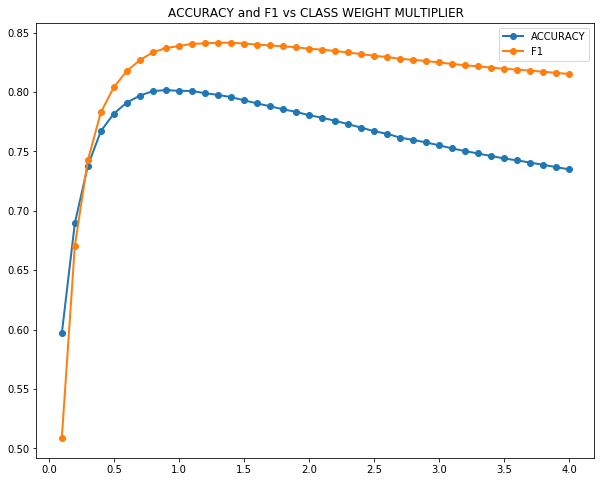

In [12]:
plt.figure(figsize=(10,8))
plt.plot(base, acc, linewidth=2, marker='o')
plt.plot(base, f1, linewidth=2, marker='o')
plt.legend(['ACCURACY', 'F1'], loc='upperright')
plt.title('ACCURACY and F1 vs CLASS WEIGHT MULTIPLIER')
plt.show;

Judging by the graph, the maximum accuracy is reached around a multiplier of 0.9 and the maximum F1 score is reached around a multiplier around 1.1 or so.  Based on this, a weight multiplier of 1.0 seems a pretty fair medium.  This is consistent with the two untuned models generated, wherein the model trained with 'balanced" class weights performed *worse* than the simple model with a 1:1 label weight ratio.

In [13]:
logbest = LogisticRegression(**log_best_params, random_state=rando_seed)
train_and_report(logbest, 5, X_bi, y_bi)


Average crossval scores for best model: 
               AVG       STD
Accuracy  0.801939  0.006362
F1        0.839441  0.005511

Time to train model on each fold was 1.84 seconds average.


This tuned model is literally super mega slightly better than the first one with no tuning.  Totes worth it!

<a id="nb"></a>
## Naive-Bayes Classifier

Due to the imbalance of gender in our dataset, my intuition tells me that using a complement Naive-Bayes model will give the best results.  Despite this, Naive-Bayes methods in general are extremely fast to train so there's really no reason not to train the whole gamut of Naive-Bayes models just to see.

### Complement Naive-Bayes

In [14]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB

clf = ComplementNB()
train_metrics, test_metrics = strat_kfold(clf, X_bi, y_bi, train_metrics=True, random_state=rando_seed)
train_test_eval(train_metrics, test_metrics)



Training crossvalidation metrics average: 
               AVG       STD
Accuracy  0.709807  0.001796
F1        0.747301  0.001808


Testing crossvalidation metrics average: 
               AVG       STD
Accuracy  0.708471  0.007372
F1        0.746041  0.008385


### Multinomial Naive-Bayes

In [15]:
clf = MultinomialNB()
train_metrics, test_metrics = strat_kfold(clf, X_bi, y_bi, train_metrics=True, random_state=rando_seed)
train_test_eval(train_metrics, test_metrics)



Training crossvalidation metrics average: 
               AVG       STD
Accuracy  0.721071  0.001754
F1        0.769839  0.001637


Testing crossvalidation metrics average: 
               AVG       STD
Accuracy  0.719947  0.005861
F1        0.768791  0.006472


### Gaussian Naive-Bayes

In [16]:
clf = GaussianNB()
train_metrics, test_metrics = strat_kfold(clf, X_bi, y_bi, train_metrics=True, random_state=rando_seed)
train_test_eval(train_metrics, test_metrics)



Training crossvalidation metrics average: 
               AVG       STD
Accuracy  0.710822  0.001465
F1        0.759459  0.001363


Testing crossvalidation metrics average: 
               AVG       STD
Accuracy  0.710708  0.004440
F1        0.759195  0.006217


### Bernoulli Naive-Bayes

In [17]:
X_bi_dummies = pd.get_dummies(X_bi)

clf = BernoulliNB()
train_metrics, test_metrics = strat_kfold(clf, X_bi_dummies, y_bi, train_metrics=True, random_state=rando_seed)
train_test_eval(train_metrics, test_metrics)



Training crossvalidation metrics average: 
               AVG       STD
Accuracy  0.597083  0.000443
F1        0.739546  0.000431


Testing crossvalidation metrics average: 
               AVG       STD
Accuracy  0.594825  0.003285
F1        0.737995  0.002651


So yeah, complement Naive-Bayes didn't work better than the other Naive-Bayes methods.  Multinomial worked the best with all other methods coming in close behind.  All methods exhibit minimal overfitting and trained fast--unfortunately, their performance is weak, too, so speed doesn't really matter.

### Tuning the Multinomial Naive-Bayes Model

In [18]:
base = list(np.arange(0.0, 1, 0.05))
param_grid = {'alpha': base}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid.fit(X_bi, y_bi)
nb_best_params = grid.best_params_
bold_print("Best hyperparameters found: ")
print(nb_best_params)

Best hyperparameters found: 
{'alpha': 0.25}


In [19]:
nbbest = MultinomialNB(**nb_best_params)
train_and_report(nbbest, 5, X_bi, y_bi)


Average crossval scores for best model: 
               AVG       STD
Accuracy  0.719947  0.005861
F1        0.768791  0.006472

Time to train model on each fold was 0.16 seconds average.


Again, still not that great for accuracy but worth trying just because of how quick it is.  It should also be noted that naive Bayesian methods really shine in situations where you have small datasets and limited features--which isn't this dataset, but it still has it's place.

<a id="svm"></a>
## Support Vector Machines

The next class of "old school" models is support vector machines--although SVMs aren't nearly as "old school" as logistic regression or Naive-Bayes.  SVMs aren't nearly as fast to train as the them, either, especially on datasets bigger than 5 - 10k rows of data.  We will only test a linear, quadratic, and radial basis function kernels here although there are many more kernels possible.  If I had a super computer or a ton of time on my hands I would include a large list of kernels with the other parameters in grid search optimization--but I don't, so I won't.  As with previous models, multiple will be built and the best will be selected for tuning.  Due to the extremely long training times for SVMs of this type, we will use a subset of the entire training data to select the best model and then train that final best model on the entire dataset.

Due to the time it takes to train each SVC, below the data is sampled to a quarter size.  This quartered dataset will be used to train and tune the SVCs.

In [8]:
from sklearn.model_selection import train_test_split

_X, X_sub, _y, y_sub = train_test_split(X_bi, y_bi, stratify=y_bi, test_size=0.25, random_state=rando_seed)
print(f"There are {len(X_sub)} points of data in this subset.")

There are 12069 points of data in this subset.


### Linear SVC

LinearSVC is the best of the SVC options in scikit-learn because it scales way better than SVC itself.  LinearSVC can scale up with more features and more rows of data linearly while the generic SVC model scales on the order of O(n<sup>2</sup>).  Unfortunately, not all data is simply linearly separable and sometimes you need to branch out into other kernels to get solid results.

In [21]:
from sklearn.svm import SVC, LinearSVC

bold_print('Linear SVC with balanced weights: ')
clf = LinearSVC(class_weight='balanced', random_state=rando_seed)
train_metrics, test_metrics = strat_kfold(clf, X_sub, y_sub, num_folds=3, train_metrics=True, random_state=rando_seed)
train_test_eval(train_metrics, test_metrics)
bold_print('\n\nLinear SVC with normal weights: ')
clf = LinearSVC(random_state=rando_seed)
train_metrics, test_metrics = strat_kfold(clf, X_sub, y_sub, num_folds=3, train_metrics=True, random_state=rando_seed)
train_test_eval(train_metrics, test_metrics)

Linear SVC with balanced weights: 


Training crossvalidation metrics average: 
               AVG       STD
Accuracy  0.596156  0.023583
F1        0.572613  0.134976


Testing crossvalidation metrics average: 
               AVG       STD
Accuracy  0.589527  0.025372
F1        0.564797  0.139260


Linear SVC with normal weights: 


Training crossvalidation metrics average: 
               AVG       STD
Accuracy  0.654954  0.127781
F1        0.605514  0.265109


Testing crossvalidation metrics average: 
               AVG       STD
Accuracy  0.651647  0.122213
F1        0.604970  0.256887


### Quadratic Kernel

In [22]:
bold_print("Binomial SVC with balanced weights: ")
clf = SVC(kernel='poly', degree=2, class_weight='balanced', random_state=rando_seed)
train_metrics, test_metrics = strat_kfold(clf, X_sub, y_sub, num_folds=3, train_metrics=True, 
                                            random_state=rando_seed)
train_test_eval(train_metrics, test_metrics)
bold_print('\n\nBinomial SVC with normal weights: ')
clf = SVC(kernel='poly', degree=2, random_state=rando_seed)
train_metrics, test_metrics = strat_kfold(clf, X_sub, y_sub, num_folds=3, train_metrics=True, 
                                            random_state=rando_seed)
train_test_eval(train_metrics, test_metrics)

Binomial SVC with balanced weights: 


Training crossvalidation metrics average: 
               AVG       STD
Accuracy  0.924310  0.000786
F1        0.935897  0.000640


Testing crossvalidation metrics average: 
               AVG       STD
Accuracy  0.791532  0.000550
F1        0.823511  0.000826


Binomial SVC with normal weights: 


Training crossvalidation metrics average: 
               AVG       STD
Accuracy  0.926009  0.001169
F1        0.939236  0.000911


Testing crossvalidation metrics average: 
               AVG       STD
Accuracy  0.794681  0.002645
F1        0.832044  0.002294


### Radial Basis Function Kernel

In [23]:
bold_print('RBF with balanced weights: ')
clf = SVC(kernel='rbf', class_weight='balanced', random_state=rando_seed)
train_metrics, test_metrics = strat_kfold(clf, X_sub, y_sub, num_folds=3, train_metrics=True, random_state=rando_seed)
train_test_eval(train_metrics, test_metrics)
bold_print('\n\nRBF with normal weights: ')
clf = SVC(kernel='rbf', random_state=rando_seed)
train_metrics, test_metrics = strat_kfold(clf, X_sub, y_sub, num_folds=3, train_metrics=True, random_state=rando_seed)
train_test_eval(train_metrics, test_metrics)

RBF with balanced weights: 


Training crossvalidation metrics average: 
               AVG       STD
Accuracy  0.939473  0.001227
F1        0.948957  0.001038


Testing crossvalidation metrics average: 
               AVG       STD
Accuracy  0.804540  0.003086
F1        0.835208  0.002558


RBF with normal weights: 


Training crossvalidation metrics average: 
               AVG       STD
Accuracy  0.939183  0.001367
F1        0.950079  0.001089


Testing crossvalidation metrics average: 
               AVG       STD
Accuracy  0.809263  0.002794
F1        0.845892  0.002438


Well, it appears that there is no consistent weighting scheme that is best between kernels, so both will have to be used to tune.  RBF and binomial SVCs also greatly outperformed linear so linear will be excluded from the tuning to decrease tuning time.

### Tuning the SVM

Looking above, it's clear that our SVM with the radial basis function kernel performs the best (followed very closely by the quadratic SVC).  It is a fair amount overfit but still outperforms every other model so far on the crossvalidation score so further tuning will be done on just these two kernels to decrease tuning time.

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import random

def rand_list(lower, upper, sample_size, random_seed=None):
    rand = []
    random.seed(random_seed)
    for i in range(sample_size):
        rand.append(random.uniform(lower, upper))
    return rand
        
num_iterations = 60
hyperparams = {'kernel': ['poly', 'rbf'], 
              'C':[0.001, 0.01, 0.1, 1, 10],
              'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
              'class_weight': [None, 'balanced']}

t0 = time.time()
rando_search = GridSearchCV(SVC(random_state=rando_seed, degree=2), hyperparams, cv=3, n_jobs=-1)
rando_search.fit(X_sub, y_sub)
bold_print("Best hyperparameters found: ")
svc_best_params = rando_search.best_params_
print(svc_best_params)
t1 = time.time()
print(f"\nIt took {round(t1-t0,2)} seconds to complete search.")

Best hyperparameters found: 
{'C': 10, 'class_weight': None, 'gamma': 0.001, 'kernel': 'rbf'}

It took 1505.5 seconds to complete search.


![Long Wait!](https://media.giphy.com/media/tXL4FHPSnVJ0A/giphy.gif)

The final SVC will only be trained on a half the data instead of all data due to training time.  These SVCs take for - ev - er to train and for the simple model exploration happening here it's not worth it to me to spend $4 worth of cloud compute just to get a full accuracy measure that could be approximated in much less.

In [ ]:
X_half, _, y_half, _ = train_test_split(X_bi, y_bi, test_size=0.5, stratify=y_bi)

from sklearn.svm import SVC
svm_clf = SVC(**svc_best_params, random_state=rando_seed)
train_and_report(svm_clf, 3, X_half, y_half)


Average crossval scores for best model: 
               AVG       STD
Accuracy  0.808750  0.005240
F1        0.843972  0.004543

Time to train model on each fold was 102.96 seconds average.


BEST PERFORMER SO FAR (barely but on half the data)! Unfortunately, the bane of my existence in terms of training time.  The differential between train and test averages indicates that there is a decent amount of overfitting occuring with this model but, fortunately, even on the test data it does better than everything so far (which is what really counts).</br>
![YES!](https://media.giphy.com/media/UbD6c9YyD0SPu/giphy.gif)

<a id='knn'></a>
## K-Nearest Neighbors 

K-nearest neighbors is a (relatively) quick and easy classification method that basically compares the answers between tests and decides if it is a male or female based on which other testers the answers are closest to.  There are multiple metrics available but using L1 ("Manhattan metric") is chosen off the bat as it allows for comparing differences of answers *within* questions.  Previous experience using a KNN classifier is not that great, however, and I don't expect this to work as well as other methods.

In [13]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5, p=2, n_jobs=-1)
train_metrics, test_metrics = strat_kfold(clf, X_sub, y_sub, train_metrics=True, random_state=rando_seed)
train_test_eval(train_metrics, test_metrics)



Training crossvalidation metrics average: 
               AVG       STD
Accuracy  0.799983  0.001359
F1        0.840333  0.001258


Testing crossvalidation metrics average: 
               AVG       STD
Accuracy  0.687549  0.013238
F1        0.752128  0.008254


### Tuning K-Nearest Neighbors

In [14]:
from sklearn.model_selection import GridSearchCV
n_neigh = [2, 4, 8, 16]
metric = [1, 2]
c_weights = ['uniform', 'distance']
param_grid = {'n_neighbors': n_neigh, 'p': metric, 'weights': c_weights}
grid = GridSearchCV(KNeighborsClassifier(algorithm='auto'), param_grid, cv=3, n_jobs=-1)
grid.fit(X_sub, y_sub)
knn_best_params = grid.best_params_
bold_print("Best hyperparameters found: ")
print(knn_best_params)

Best hyperparameters found: 
{'n_neighbors': 16, 'p': 2, 'weights': 'uniform'}


Again, half the dataset is used to train the KNN classifier because it takes too long for a simple exploration of models on this data.

In [15]:
knn_clf = KNeighborsClassifier(algorithm='auto', **knn_best_params, n_jobs=-1)
train_and_report(knn_clf, 5, X_bi, y_bi)


Average crossval scores for best model: 
               AVG       STD
Accuracy  0.733371  0.009402
F1        0.787101  0.009031

Time to train model on each fold was 153.78 seconds average.


Sooooo, yeah.  Not great.  I'd rather trade the slight increase in accuracy for the massive increase in speed and go with a Naive-Bayes model instead.

<a id="trees"></a>
## Ensemble Decision Trees

Next up are my favorite class of traditional models:  ensemble decision trees.  Random forests and gradient boosted trees will both be looked at and I expect them to outperform all previous models on our large, tabular dataset.  Training time unfortunately sucks for these (though *usually* not as bad as SVMs) as well, so I predict some boredom in the coming minutes.

### Random Forest

Random forest classifiers are an excellent choice for data such as this.  The main danger that will be run in to is the tendency to overfit--the accuracy on the training data will likely be close to 1.0 but not nearly that high on the test set without significant tuning to the model.  We will start off with a simple random forest of 100 estimators.

In [16]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
train_metrics, test_metrics = strat_kfold(clf, X_sub, y_sub, num_folds=5, train_metrics=True, 
                                            verbose=True, random_state=rando_seed)
train_test_eval(train_metrics, test_metrics)




Training crossvalidation metrics average: 
          AVG  STD
Accuracy  1.0  0.0
F1        1.0  0.0


Testing crossvalidation metrics average: 
               AVG       STD
Accuracy  0.769325  0.006762
F1        0.821980  0.004901


### Gradient Boosted

I expect the gradient boosted decision tree to train faster than the random forest classifier but the predictive power is usually hit-or-miss compared to random forests without significant tuning.

In [15]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(n_estimators=200, class_weight='balanced', random_state=rando_seed, n_jobs=-1)
train_metrics, test_metrics = strat_kfold(clf, X_sub, y_sub, num_folds=5, train_metrics=True, 
                                            verbose=True, random_state=rando_seed)
train_test_eval(train_metrics, test_metrics)




Training crossvalidation metrics average: 
               AVG       STD
Accuracy  0.983470  0.001187
F1        0.986157  0.001008


Testing crossvalidation metrics average: 
               AVG       STD
Accuracy  0.798576  0.007299
F1        0.831600  0.005846


### Tuning the Gradient Boosted Model

Ensemble decision trees have a higher training time than simple methods like logistic regression as well as many more hyperparameters--each over a large range.  This makes performing a grid search over hyperparameters extremely time and resource intensive.  Luckily, James Bergstra and Yoshua Bengio have shown that random searches can match or beat the performance of a grid search in a large number of cases<sup>[[1]](#berg_beng)</sup>.  The random search method is what we'll use to tune our categorical gradient boosted model below.  The beauty with random search is that testing only 60 random hyperparameter combinations is enough to get within 5% of the model's max accuracy with 95% confidence.
<br/>
<br/>
<a id="berg_beng"></a>
    [1] Bergstra, J. & Bengio, Y. Random Search for Hyper-Parameter Optimization. *Journal of Machine Learning Research* 13: 281-305, 2012.  Retrieved from &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf>

In [16]:
from sklearn.model_selection import RandomizedSearchCV
import random

def rand_list(lower, upper, sample_size, random_seed=None):
    rand = []
    random.seed(random_seed)
    for i in range(sample_size):
        rand.append(random.uniform(lower, upper))
    return rand

num_iterations = 60
hyperparams = {'max_depth':list(range(1, 16)), 
              'loss_function': ['Logloss', 'CrossEntropy'], 
              'num_leaves':list(range(2, 150)),
              'learning_rate': rand_list(.001, 0.3, num_iterations, random_seed=rando_seed+42),
              'n_estimators': list(range(20, 1200)),
              'max_bin': [2,3,4,5,6]}

t0 = time.time()
rando_search = RandomizedSearchCV(LGBMClassifier(random_state=rando_seed), hyperparams, 
                                  random_state=rando_seed+72, n_iter=num_iterations, cv=3, n_jobs=-1)
rando_search.fit(X_sub, y_sub)
bold_print("Best hyperparameters found: ")
grad_tree_best_params = rando_search.best_params_
print(grad_tree_best_params)
t1 = time.time()
print(f"\nIt took {round(t1-t0,2)} seconds to complete search.")

Best hyperparameters found: 
{'num_leaves': 125, 'n_estimators': 879, 'max_depth': 10, 'max_bin': 6, 'loss_function': 'Logloss', 'learning_rate': 0.23373481573160126}

It took 201.71 seconds to complete search.


In [17]:
bestgrad = LGBMClassifier(silent=True, random_state=rando_seed, **grad_tree_best_params)
train_and_report(bestgrad, 5, X_bi, y_bi)


Average crossval scores for best model: 
               AVG       STD
Accuracy  0.816171  0.006028
F1        0.851206  0.005193

Time to train model on each fold was 12.46 seconds average.


### Categorical Gradient Boosted

In [21]:
from catboost import CatBoostClassifier

X_bi_cat = X_bi.astype('category')
X_sub_cat = X_sub.astype('category')

clf = CatBoostClassifier(n_estimators=200, silent=True, random_state=rando_seed)
kwargs = {'silent': True}
train_metrics, test_metrics = strat_kfold(clf, X_sub_cat, y_sub, num_folds=5, train_metrics=True, 
                                            verbose=True, fit_kwargs=kwargs, random_state=rando_seed)
train_test_eval(train_metrics, test_metrics)




Training crossvalidation metrics average: 
               AVG       STD
Accuracy  0.913850  0.002058
F1        0.929759  0.001604


Testing crossvalidation metrics average: 
               AVG       STD
Accuracy  0.803878  0.003125
F1        0.841411  0.002201


Hhmmm, interesting.  The random forest was waaaay overfit (unsurprisingly, random forests take a decent amount of tuning to keep from overfitting) while the gradient boosted tree was not-quite-as overfit (hehe, just kidding--it was definitely overfit too).  Counter to my initial intuition, the gradient boosted tree did better on the test set right out of the box.  The real shocker is that the categorical gradient boosted tree did better than both in terms of accuracy and was much less overfit (but still somewhat overfit).

Below, we "shrink" the categorical variables by reducing gradation in answers for each feature.  Instead of "disagree" and "slightly disagree" will be binned together, "neither agree nor disagree" and "no answer" will stay their own category, and "agree" or "slightly agree" will be binned together.  CatBoostClassifier will then be applied to these new categories

In [22]:
def shrink(num):
    if (num==1) or (num==2):
        return 1
    elif (num==3):
        return 2
    elif (num>3):
        return 3
    else:
        return 0
X_sub_shrink = X_sub.copy()
X_sub_shrink = X_sub_shrink.applymap(shrink)
X_sub_shrink = X_sub_shrink.astype('category')
X_sub_shrink.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
42884,3,3,3,3,3,3,2,2,1,2,...,3,1,3,3,1,3,3,2,2,1
36053,1,2,2,2,3,2,2,2,2,2,...,3,2,3,3,2,2,2,1,2,2
37399,3,3,3,3,3,3,3,1,1,1,...,1,1,3,3,1,1,3,3,3,3
25550,3,3,3,3,3,3,3,3,1,1,...,3,2,1,3,3,1,1,1,1,1
38483,3,3,3,3,3,2,3,3,1,1,...,3,3,2,2,1,1,2,1,3,2


In [23]:
clf = CatBoostClassifier(n_estimators=200, silent=True, random_state=rando_seed)
train_metrics, test_metrics = strat_kfold(clf, X_sub_shrink, y_sub, num_folds=5, train_metrics=True, 
                                            verbose=True, random_state=rando_seed)
train_test_eval(train_metrics, test_metrics)




Training crossvalidation metrics average: 
               AVG       STD
Accuracy  0.902332  0.001781
F1        0.920595  0.001439


Testing crossvalidation metrics average: 
               AVG       STD
Accuracy  0.786645  0.003725
F1        0.828332  0.002225


**Super cool**.  Removing all gradation in each sentiment results in a net loss of only 1.5% crossvalidation accuracy!  What this means is that just the sentiment itself--and not gradation--carry almost all of the information in the dataset.  This is important to note for model tuning, as removing sentiment gradation prior to tuning hyperparameters (for example, adding depth and n_estimators--each of which tend to cause more overfitting as they increase) may help us increase crossvalidation accuracy.

### Tuning the Categorical Gradient Boosted Model

As with SVCs above, ensemble tree methods come with a lot of hyperparameters and higher training time so all will be tuned with random search.

In [25]:
num_iterations = 60
hyperparams = {'depth':list(range(1, 16)), 
              'loss_function': ['Logloss', 'CrossEntropy'], 
              'l2_leaf_reg':list(range(2, 64)),
              'learning_rate': rand_list(.001, 0.3, num_iterations, random_seed=rando_seed+42),
              'n_estimators': list(range(20, 1200))}

t0 = time.time()
rando_search = RandomizedSearchCV(CatBoostClassifier(silent=True, random_state=rando_seed), hyperparams, 
                                  random_state=rando_seed+72, n_iter=num_iterations, cv=3, n_jobs=-1)
rando_search.fit(X_sub_cat, y_sub)
bold_print("Best hyperparameters found: ")
cat_tree_best_params = rando_search.best_params_
print(cat_tree_best_params)
t1 = time.time()
print(f"\nIt took {round(t1-t0,2)} seconds to complete search.")

Best hyperparameters found: 
{'n_estimators': 858, 'loss_function': 'Logloss', 'learning_rate': 0.12046437963028535, 'l2_leaf_reg': 61, 'depth': 4}

It took 24501.67 seconds to complete search.


In [26]:
bestcat = CatBoostClassifier(silent=True, random_state=rando_seed, **cat_tree_best_params)
train_and_report(bestcat, 5, X_bi, y_bi)


Average crossval scores for best model: 
               AVG       STD
Accuracy  0.816233  0.005761
F1        0.850406  0.005274

Time to train model on each fold was 27.95 seconds average.


Eh, overall accuracy not that great but about on par with the other models.  F1 score is definitely on the higher end of models (which is good), but overall accuracy is definitely not worth the extra tuning time.

<a id="conclusion"></a>
## Conclusions

From this big trip around the zoo of models, three classes of models really stand out in terms of performance against the rest: logarithmic regression, support vector classifiers, and ensemble decision trees (specifically both gradient boosted ones).  Logarithmic regression and SVCs ended up in the 80 - 81% accuracy range and both the categorical and normal gradient boosted trees ended up in the 81 - 82% accuracy range.

Of these, logarithmic regression was by far the fastest to train, followed by normal gradient boosted decision trees.  SVCs and categorical gradient boosted trees both took way too long to train--so long, in fact, that the final tuned SVC was only trained on half the data so as to not waste a ton of money on simple model exploration.  This is a good indication that logarithmic regression and gradient boosted trees are solid avenues of approach for building a more predictive model--along with additional data processing techniques like actually dealing with missing values in the personality questions and better encoding of the variables.  Additionally, with the categorical gradient boosted model there was minimal accuracy loss for significantly compacting the answer categories for each question--which may make it a reasonable approach to take when building a final model in order to combat overfitting.
<br/>
<br/>
![Goodbye!](https://media0.giphy.com/media/YC2ohKyxNlXq0/giphy.gif)